In [1]:
import sys
sys.path.insert(0,"../Classes")
from DataClass import DataLoader
from GaborKernelClass import GaborFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from tqdm import tqdm

In [2]:
def uq_w_ind(img):
    vs,inds = np.unique(img,return_inverse=True)
    miss = [a for a in range(256) if a not in vs]
    for a in miss:
        vs = np.insert(vs,a,a)
        inds[inds>a]=inds[inds>a]+1
    return vs,inds
def interp_img(img,interps):
    img_out = np.zeros((img.shape),np.float32)
    for a in range(3):
        vals,bin_idx = uq_w_ind(img[:,:,a])
        img_out[:,:,a] = interps[a][bin_idx].reshape((img.shape[0:2]))
    return img_out

In [3]:
def depth_scale(X):
    bsum = np.sum(X,axis=1)
    bsum[bsum==0] = 1
    out = X/np.moveaxis([bsum]*X.shape[1],(0,1),(1,0))
    return out

In [4]:
def do_col_con(gf,inds,img):
    shapes = img.shape
    nkerns = len(gf.kernels)
    
    red_ind = inds[inds<nkerns]
    gf2 = GaborFeatures()
    gf2.kernels = np.array(gf.kernels)[red_ind]
    red_feats = np.reshape(gf2.convolve_kernels(img,["red"]),(shapes[0]*shapes[1],-1)).astype(np.float32)
    
    green_ind = inds[np.logical_and(nkerns<=inds,inds<nkerns*2)]-nkerns
    gf2 = GaborFeatures()
    gf2.kernels = np.array(gf.kernels)[green_ind]
    green_feats = np.reshape(gf2.convolve_kernels(img,["green"]),(shapes[0]*shapes[1],-1)).astype(np.float32)
    
    blue_ind = inds[np.logical_and(2*nkerns<=inds,inds<nkerns*3)]-2*nkerns
    gf2 = GaborFeatures()
    gf2.kernels = np.array(gf.kernels)[blue_ind]
    blue_feats = np.reshape(gf2.convolve_kernels(img,["blue"]),(shapes[0]*shapes[1],-1)).astype(np.float32)
    
    out = np.hstack((red_feats,green_feats,blue_feats)).astype(np.float32)
    return out

In [5]:
def fs06(depth,inds):
    shapes = depth.shape
    
    gf = GaborFeatures()
    gf.add_log_kernels(32,3,2)
    gf.add_log_kernels(64,3,2)
    gf.add_log_kernels(128,3,2)
    gf.resize_kernels(0.9)
    #No colours so we can index directly
    kerns = np.array(gf.kernels)[inds]
    gf = GaborFeatures()
    gf.kernels = kerns
    
    feats = gf.convolve_kernels(depth,["red"])
    
    feats = np.reshape(feats,(shapes[0],shapes[1],-1))
    feats = cv2.resize(feats,(4096,4096))
    feats = np.reshape(feats,(4096*4096,-1))
    
    feats = depth_scale(feats)
    
    return feats

def fs07(depth,inds):
    shapes = depth.shape
    
    gf = GaborFeatures()
    gf.add_log_kernels(32,8,2)
    gf.add_log_kernels(64,8,2)
    gf.add_log_kernels(128,8,2)
    gf.resize_kernels(0.9)
    #No colours so we can index directly
    kerns = np.asarray(gf.kernels)[inds]
    gf = GaborFeatures()
    gf.kernels = kerns
    
    feats = gf.convolve_kernels(depth,["red"])
    
    feats = np.reshape(feats,(shapes[0],shapes[1],-1))
    feats = cv2.resize(feats,(4096,4096))
    feats = np.reshape(feats,(4096*4096,-1))
    
    feats = depth_scale(feats)
    
    return feats

def fs08(flat_LAB,inds):
    freqs = [1]
    theta = 2*np.pi*np.arange(0,8)/8
    band  = [0.01,0.1,1]
    std   = [1]
    off   = 2*np.pi*np.arange(0,4)/4
    
    gf = GaborFeatures()
    gf.add_kernels(freqs,theta,band,std,off)
    
    feats = do_col_con(gf,inds,flat_LAB)
    return feats

def fs09(flat_LAB,inds):
    gf = GaborFeatures()
    
    gf.add_log_kernels(32,3,2)
    gf.add_log_kernels(64,3,2)
    gf.add_log_kernels(128,3,2)
    
    gf.resize_kernels(0.9)
    
    feats = do_col_con(gf,inds,flat_LAB)
    return feats

def fs10(flat_LAB,inds):
    gf = GaborFeatures()
    
    gf.add_log_kernels(32,8,2)
    gf.add_log_kernels(64,8,2)
    gf.add_log_kernels(128,8,2)
    
    gf.resize_kernels(0.9)
    
    feats = do_col_con(gf,inds,flat_LAB)
    return feats

In [6]:
def get_features(flat_LAB,depth,inds):
    shapes = flat_LAB.shape
    
    f6  = fs06(depth,np.array(inds[0]))
    f7  = fs07(depth,np.array(inds[1]))
    f8  = fs08(flat_LAB,np.array(inds[2]))
    f9  = fs09(flat_LAB,np.array(inds[3]))
    f10 = fs10(flat_LAB,np.array(inds[4]))
    feats = np.hstack((f6,f7,f8,f9,f10))
    feats = np.reshape(feats,(shapes[0],shapes[1],-1))
    return feats

In [7]:
def rgb2lab(flat):
    img = cv2.cvtColor(flat/255,cv2.COLOR_RGB2Lab)
    if True:
        img[:,:,0] = img[:,:,0]*(255/100)
        img[:,:,1] = img[:,:,1]+128
        img[:,:,2] = img[:,:,2]+128
    return img

In [16]:
from scipy.interpolate import CubicSpline
from skimage.filters import gaussian

def make_pred(dataloader,index,inds,interps=None):
    flat = dataloader.get_data("flat",[index])[0].astype(np.float32)
    if interps is not None:
        flat = interp_img(flat,interps)
    flat = rgb2lab(flat)
    depth = np.moveaxis([dataloader.get_data("depth",[index])[0]],(0,1,2),(2,0,1))
    feats = np.reshape(get_features(flat,depth,inds),(4096*4096,-1))
    pred = np.reshape(clf.predict(feats),(4096,4096))
    morphed = gaussian(pred,sigma=100)>0.5
    return morphed

def make_pred2(dataloader,index,inds,interps=None):
    flat = dataloader.get_data("flat",[index])[0].astype(np.float32)
    if interps is not None:
        flat = interp_img(flat,interps)
    flat = rgb2lab(flat)
    depth = np.moveaxis([dataloader.get_data("depth",[index])[0]],(0,1,2),(2,0,1))
    feats = np.reshape(get_features(flat,depth,inds),(4096*4096,-1))
    pred = np.reshape(clf.predict(feats),(4096,4096))
    return pred

In [9]:
def printave(a):
    strout = "Ave performance:"
    for v in a:
        strout+="\n    "+str(v)
    print(strout)

from tqdm import tqdm
from IPython.display import clear_output
from ScorerClass import scorer

def test_acc(dataloader,inds,interps=None,check_region=False):
    scorer_ = scorer()
    all_accs = []
    ave_acc = [0]
    for a in tqdm(range(len(dataloader.classfiles))):
        printave(ave_acc)
        p = make_pred(dataloader,a,inds,interps=interps)
        y = dataloader.get_data("class",[a])[0][:,:,0].astype(bool)
        if check_region:
            reg = dataloader.get_data("region",[a])[0][:,:,0].astype(bool)
            m1 = scorer_.acc(y[reg],p[reg])
            m2 = scorer_.sens(y[reg],p[reg])
            m3 = scorer_.spec(y[reg],p[reg])
            m4 = scorer_.VOI(y[reg],p[reg])
            m5 = scorer_.GCE(y[reg],p[reg])
            acc = [m1,m2,m3,m4,m5]
        else:
            m1 = scorer_.acc(y,p)
            m2 = scorer_.sens(y,p)
            m3 = scorer_.spec(y,p)
            m4 = scorer_.VOI(y,p)
            m5 = scorer_.GCE(y,p)
            acc = [m1,m2,m3,m4,m5]
        clear_output(wait=True)
        all_accs.append(acc)
        ave_acc = np.mean(all_accs,axis=0)
    print("Ave acc:",ave_acc)

In [10]:
inds = [
    [16,22,25,28],
    [59,67,68,69,85],
    [101,103,194,218,242,266],
    [61,64,65,102,103,106,107],
    [100,114,126,161,163,165,166,167,168,170,171,172,173,174,175,283,284,285]
]

In [11]:
from joblib import load
clf = load("The40clf.joblib")

In [12]:
dataloader = DataLoader()
dataloader.load_std_folder("../../../Data/STD_Folder")
#dataloader.load_std_folder("../../../Data/DATA_FROM_EARLIER_PHOTOS/converted")
dataloader.parse_biclass()

In [20]:
import matplotlib.pyplot as plt

def plot_ppy(a,b,c):
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel("(a)",fontsize=18)
    ax1.patch.set_edgecolor('black')
    ax1.patch.set_linewidth('1')  
    ax1.imshow(a)
    
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel("(b)",fontsize=18)
    ax2.patch.set_edgecolor('black')
    ax2.patch.set_linewidth('1')  
    ax2.imshow(b)
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_xlabel("(c)",fontsize=18)
    ax3.patch.set_edgecolor('black')
    ax3.patch.set_linewidth('1')  
    ax3.imshow(c)
    
    return f

0.8681148290634155


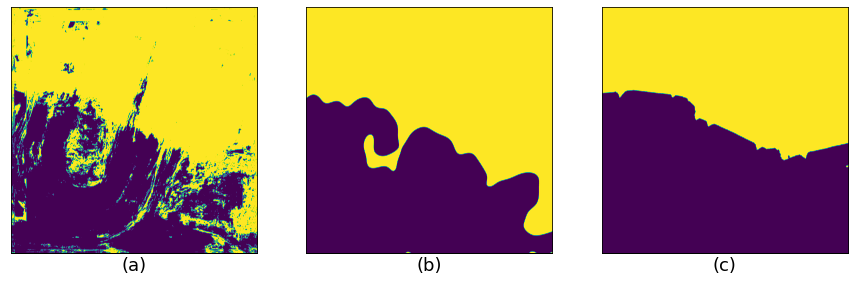

In [21]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore',category=np.VisibleDeprecationWarning)

index = 5
p = make_pred2(dataloader,index,inds)
p2 = make_pred(dataloader,index,inds)
y = dataloader.get_data("class",[index])[0][:,:,0].astype(bool)

f = plot_ppy(p,p2,y)
f.savefig("pred_smo_40.png")
print(np.mean(p==y))

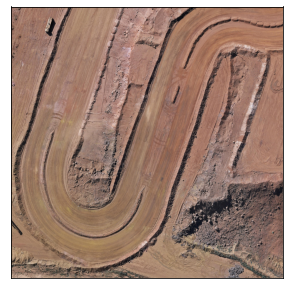

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(dataloader.get_data("flat",[index])[0])
plt.xticks([])
plt.yticks([])
plt.savefig("pred_flat_img.png")
plt.show()

In [13]:
import warnings
warnings.filterwarnings(action='ignore',category=np.VisibleDeprecationWarning)

test_acc(dataloader,inds)

100%|██████████| 79/79 [3:03:51<00:00, 139.64s/it]

Ave acc: [0.93642071 0.91690424 0.81404553 0.3324033  0.8605736 ]


In [14]:
dataloader = DataLoader()
#dataloader.load_std_folder("../../../Data/STD_Folder")
dataloader.load_std_folder("../../../Data/DATA_FROM_EARLIER_PHOTOS/converted")
dataloader.parse_biclass()

In [15]:
import warnings
warnings.filterwarnings(action='ignore',category=np.VisibleDeprecationWarning)
interps = np.load("interps.npy")
test_acc(dataloader,inds,interps=interps)

100%|██████████| 77/77 [2:17:31<00:00, 107.16s/it]

Ave acc: [0.76108625 0.7417108  0.62039159 0.7194864  0.88008878]


In [16]:
dataloader = DataLoader()
dataloader.load_std_folder("../../../Data/DataSet2/converted",get_valid_region=True)

In [17]:
import warnings
warnings.filterwarnings(action='ignore',category=np.VisibleDeprecationWarning)
interps = np.load("interps_newdata.npy")
test_acc(dataloader,inds,interps=interps,check_region=True)

100%|██████████| 36/36 [43:39<00:00, 72.76s/it]

Ave acc: [0.73704488 0.75806831 0.73859587 0.59457187 0.74082688]
